# Process name curation

When modeling and analyzing the detail of the behaviour of processes,
it is helpful to contrast it with some notional intent of computation behind the process.
For instance,
given a sequence of low-level events captured from an instance of Microsoft Word,
one keeps in mind that they have at hand a word processor,
and may thus measure whether these events make sense for a word processor,
or rather are surprising.

A useful feature in this sense is thus the `process_name` attached to each PID hash.
To address an important objection quickly:
process names for programs such as shells and language interpreters are not useful in this sense.
These names mask a variety of computational intents behind generic names such as `cmd.exe`, `python.exe` or `svchost.exe`.
While this is true,
the large majority of programs on Windows actually serve a set of computing purposes that is narrow enough to act as useful mental labels.
The work of curation done here aims at valorizing these imperfect labels.

The `process_name` feature gets populated by Wintap by extracting it from metadata generated by the Windows Auditing service.
Unfortunately, many software authors adorn their process names with trivial, transient information.
As such, something like the updater program for Google's Chrome browser carries multiple distinct names:
`chrome_updater_A.exe`, `chrome_updater_A1.exe`, `chrome_updater_B.exe`, etc.
The following notebook works towards detecting these declinations of common radicals,
so as to unify the corresponding PID hashes under joint equivalence classes.

In [1]:
%load_ext autoreload
%load_ext dotenv
#%load_ext quak
%load_ext sql

Tip: You may define configurations in /work/home/hamelin/Wintap-Analytics/2025-acme4-explore/pyproject.toml or /work/home/hamelin/.jupysql/config.

Did not find user configurations in /work/home/hamelin/Wintap-Analytics/2025-acme4-explore/pyproject.toml.

In [2]:
%autoreload 1
%aimport acme4_explore

In [3]:
%dotenv

In [4]:
%%time
import acme4_explore
import datamapplot as dmp
from fast_hdbscan import HDBSCAN
import io
import json
import logging as lg
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import re
from sentencepiece import SentencePieceTrainer, SentencePieceProcessor
from sklearn.metrics.pairwise import paired_distances
from tqdm.auto import tqdm, trange
import umap
import vectorizers as vz
import vectorizers.transformers as vzt
import zstandard as zstd

CPU times: user 35.1 s, sys: 1.59 s, total: 36.7 s
Wall time: 26.2 s


In [24]:
tqdm.pandas()

In [5]:
lg.basicConfig(**acme4_explore.logging_config())
LOG = lg.getLogger("notebook")

In [6]:
db = acme4_explore.connect_db()
%sql db --alias duckdb
%config SqlMagic.displaycon=False
%config SqlMagic.autopandas=True

Let's first gather unique process names out of the dataset.

In [13]:
%%sql process_names <<
select process_name as name, count(pid_hash) as num_processes
from process
where process_name is not null
group by process_name
order by num_processes desc, process_name desc

In [14]:
process_names

,name,num_processes
0,conhost.exe,1244024
1,wmic.exe,283125
2,mergehelper.exe,122882
3,svchost.exe,15028
4,updater.exe,9939
...,...,...
419,128.0.6613.121_128.0.6613.120_chrome_updater.exe,1
420,128.0.6613.114_chrome_installer.exe,1
421,128.0.6613.114_128.0.6613.86_chrome_updater.exe,1
422,127.0.6533.122_127.0.6533.120_chrome_updater.exe,1


The process name multiplication phenomenon we are trying to counter here is examplified by the `..._chrome_updater.exe` programs we observe,
differentiated only by version numbers.
Let's take a closer look:

In [16]:
%%sql
select *
from process_names
where name like '%chrome_updater.exe'

,name,num_processes
0,128.0.6613.119_128.0.6613.114_chrome_updater.exe,3
1,128.0.6613.138_128.0.6613.121_chrome_updater.exe,2
2,128.0.6613.120_128.0.6613.119_chrome_updater.exe,2
3,128.0.6613.86_128.0.6613.85_chrome_updater.exe,1
4,128.0.6613.138_128.0.6613.137_chrome_updater.exe,1
5,128.0.6613.137_128.0.6613.120_chrome_updater.exe,1
6,128.0.6613.121_128.0.6613.120_chrome_updater.exe,1
7,128.0.6613.114_128.0.6613.86_chrome_updater.exe,1
8,127.0.6533.122_127.0.6533.120_chrome_updater.exe,1


These 9 processes can be understood to have similar behaviour:
they are all Chrome updaters,
regardless of the moniker differences.
To surface these equivalence classes between process names,
we will apply a data representation technique:

1. Break the process names into common substrings;
2. Vectorize each name as substring counts;
3. Reduce vector dimension;
4. Cluster the low-dimension vectors by density,

under the assumption that if many names are made of the same substrings,
they will be close to each other in this vector space.

We use Google's [SentencePiece](https://github.com/google/sentencepiece) to discover a vocabulary of common substrings,
which we'll call _tokens_.

In [17]:
%%time
tkzr_process_names = io.BytesIO()
SentencePieceTrainer.train(
    sentence_iterator=iter(process_names["name"]),
    model_writer=tkzr_process_names,
    vocab_size=.8 * process_names["name"].nunique(),
    split_by_unicode_script=False,
    split_by_number=False,
    split_by_whitespace=False,
    split_digits=False,
    hard_vocab_limit=False,
)

CPU times: user 31.4 ms, sys: 7.21 ms, total: 38.6 ms
Wall time: 37.4 ms


sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input_format: 
  model_prefix: 
  model_type: UNIGRAM
  vocab_size: 339
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 0
  split_by_number: 0
  split_by_whitespace: 0
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 0
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differential_privacy: 0
  differential_privacy_noise_level: 0


In [19]:
process_names["tokens_raw"] = SentencePieceProcessor(
    model_proto=tkzr_process_names.getvalue()
).encode(list(process_names["name"]), out_type=str)
process_names

,name,num_processes,tokens_raw
0,conhost.exe,1244024,"[▁con, host., exe]"
1,wmic.exe,283125,"[▁wmi, c, ., exe]"
2,mergehelper.exe,122882,"[▁m, e, r, g, e, hel, per, ., exe]"
3,svchost.exe,15028,"[▁, svc, host., exe]"
4,updater.exe,9939,"[▁, updater, ., exe]"
...,...,...,...
419,128.0.6613.121_128.0.6613.120_chrome_updater.exe,1,"[▁128.0.6613., 1, 2, 1, _, 128.0.6613.120_, ch..."
420,128.0.6613.114_chrome_installer.exe,1,"[▁128.0.6613.114_, chrome_, installer., exe]"
421,128.0.6613.114_128.0.6613.86_chrome_updater.exe,1,"[▁128.0.6613.114_, 128.0.6613.86_, chrome_, up..."
422,127.0.6533.122_127.0.6533.120_chrome_updater.exe,1,"[▁127.0.6533.12, 2_127.0., 6, 5, 3, 3, ., 1, 2..."


Let's filter these tokens down:
we remove the long lower trait
(Unicode point 9601)
indicating start of word,
as well as the suffix `.exe`
any token building up the end of a name may be carrying.
After this editing,
any token that ends up made up of less than 2 characters is rejected.

In [30]:
def edit_token(token):
    if token.startswith(chr(9601)):
        token = token[1:]
    if token.endswith("exe"):
        token = token[:-3]
    if token.endswith("."):
        token = token[:-1]
    return token.strip()

In [33]:
process_names["tokens"] = process_names["tokens_raw"].progress_map(
    lambda tokens: [
        token
        for token in (edit_token(raw) for raw in tokens)
        if len(token) >= 2
    ]
)
process_names

  0%|          | 0/424 [00:00<?, ?it/s]

,name,num_processes,tokens_raw,tokens_edited,tokens
0,conhost.exe,1244024,"[▁con, host., exe]","[con, host, ]","[con, host]"
1,wmic.exe,283125,"[▁wmi, c, ., exe]","[wmi, c, , ]",[wmi]
2,mergehelper.exe,122882,"[▁m, e, r, g, e, hel, per, ., exe]","[m, e, r, g, e, hel, per, , ]","[hel, per]"
3,svchost.exe,15028,"[▁, svc, host., exe]","[, svc, host, ]","[svc, host]"
4,updater.exe,9939,"[▁, updater, ., exe]","[, updater, , ]",[updater]
...,...,...,...,...,...
419,128.0.6613.121_128.0.6613.120_chrome_updater.exe,1,"[▁128.0.6613., 1, 2, 1, _, 128.0.6613.120_, ch...","[128.0.6613, 1, 2, 1, _, 128.0.6613.120_, chro...","[128.0.6613, 128.0.6613.120_, chrome_, updater]"
420,128.0.6613.114_chrome_installer.exe,1,"[▁128.0.6613.114_, chrome_, installer., exe]","[128.0.6613.114_, chrome_, installer, ]","[128.0.6613.114_, chrome_, installer]"
421,128.0.6613.114_128.0.6613.86_chrome_updater.exe,1,"[▁128.0.6613.114_, 128.0.6613.86_, chrome_, up...","[128.0.6613.114_, 128.0.6613.86_, chrome_, upd...","[128.0.6613.114_, 128.0.6613.86_, chrome_, upd..."
422,127.0.6533.122_127.0.6533.120_chrome_updater.exe,1,"[▁127.0.6533.12, 2_127.0., 6, 5, 3, 3, ., 1, 2...","[127.0.6533.12, 2_127.0, 6, 5, 3, 3, , 1, 2, 0...","[127.0.6533.12, 2_127.0, chrome_, updater]"


This representation inevitably leaves some process name represented by no token at all.
Let's look them up.

In [293]:
ALIASES = {}

In [34]:
%%sql
select name, num_processes
from process_names
where length(tokens) == 0

,name,num_processes
0,sc.exe,528
1,csrss.exe,203
2,dwm.exe,184
3,csc.exe,147
4,wlrmdr.exe,76
5,na.exe,63
6,idle.exe,57
7,logman.exe,31
8,py.exe,24
9,mmc.exe,17


These process names effectively all make up their own singleton equivalence classes.
For process names that do find a representation under our token vocabulary,
we carry on.
First up, vectorization by token counts.

In [37]:
%%sql process_names_rep <<
select name, num_processes, tokens
from process_names
where length(tokens) > 0

In [38]:
process_names_rep

,name,num_processes,tokens
0,conhost.exe,1244024,"[con, host]"
1,wmic.exe,283125,[wmi]
2,mergehelper.exe,122882,"[hel, per]"
3,svchost.exe,15028,"[svc, host]"
4,updater.exe,9939,[updater]
...,...,...,...
395,128.0.6613.121_128.0.6613.120_chrome_updater.exe,1,"[128.0.6613, 128.0.6613.120_, chrome_, updater]"
396,128.0.6613.114_chrome_installer.exe,1,"[128.0.6613.114_, chrome_, installer]"
397,128.0.6613.114_128.0.6613.86_chrome_updater.exe,1,"[128.0.6613.114_, 128.0.6613.86_, chrome_, upd..."
398,127.0.6533.122_127.0.6533.120_chrome_updater.exe,1,"[127.0.6533.12, 2_127.0, chrome_, updater]"


In [40]:
%%time
vzr_process_names = vz.NgramVectorizer().fit(process_names_rep["tokens"])
counts = vzr_process_names._train_matrix
counts

CPU times: user 4.68 ms, sys: 2.92 ms, total: 7.6 ms
Wall time: 7.11 ms


<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 908 stored elements and shape (400, 276)>

We reduce dimension while preserving the similarity structure using UMAP.

In [87]:
%%time
u = umap.UMAP(metric="hellinger", unique=True).fit(counts)
u

/work/home/hamelin/Wintap-Analytics/2025-acme4-explore/.venv/lib/python3.13/site-packages/umap/umap_.py:127: UserWarning: A few of your vertices were disconnected from the manifold.  This shouldn't cause problems.
Disconnection_distance = 1 has removed 123342 edges.
It has only fully disconnected 17 vertices.
Use umap.utils.disconnected_vertices() to identify them.
  warn(


CPU times: user 4min 3s, sys: 7.98 ms, total: 4min 3s
Wall time: 4.09 s


,n_neighbors,15
,n_components,2
,metric,'hellinger'
,metric_kwds,None
,output_metric,'euclidean'
,output_metric_kwds,None
,n_epochs,None
,learning_rate,1.0
,init,'spectral'
,min_dist,0.1
,spread,1.0


<div class="alert alert-warning">
UMAP modeling is not reproducible, nor are HDBSCAN clusterings.
Thus, as somebody else runs the notebook again,
the clusters will be different,
as well as the data map and the disconnectionof some of the count vectors from the graph representing the high-dimension manifold on which they exist.
However, in principle, I dare presume one would converge on the same process name equivalence classes.
</div>

As in this case
UMAP did disconnect a number of processes, we will examine the corresponding data.

In [91]:
is_disconnected = umap.utils.disconnected_vertices(u)
process_names_rep.loc[is_disconnected].sort_values("tokens")

,name,num_processes,tokens
145,liteagent.exe,15,[agent]
321,magnify.exe,2,[agn]
231,chcp.com,5,[chcp.com]
109,chcp.com.exe,28,[chcp.com]
283,iexplore.exe,3,[explore]
383,explorerr2.exe,1,[explorerr]
250,explorerr.exe,4,[explorerr]
382,explorerr3.exe,1,[explorerr]
331,explorerr1.exe,2,[explorerr]
381,explorerr4.exe,1,[explorerr]


Many interesting phenomena are shown in the table above.
First off, there are executables such as `chcp` that are declined with distinct extensions.

| name          | num\_processes |
|:--------------|---------------:|
| chcp.com      | 5              |
| chcp.com.exe  | 28             |
| more.com      | 2              |
| more.com.exe  | 2              |
| tree.com      | 1              |
| tree.com.exe  | 3              |

The `.exe` declinations are hidden-in-plain-sight spoofs of the classic DOS utilities compiled under the ancient PE format `.com`.
As such, they likely belong to red team activity, who also triggered the execution of some of the `.com` programs to help contrast the two activities.
These pairs of names thus respectively belong to distinct equivalence classes.
A similar pattern we notice is `.exe` extension suffixed to `.tmp`.

| name          | num\_processes |
|:--------------|---------------:|
| tcm.tmp.exe   | 3              |
| tcm.tmp       | 5              |

This one is more pernicious,
as it looked at first glance like a software installation gambit.
However, `.tmp` as an extension apparently is recognized as suitable to PE executables by the Windows shell.
People use that to [dissimulate their use of other binaries necessary for escalating attacks](https://cyberbuff.github.io/TheAtomicPlaybook/tactics/defense-evasion/T1140.html#atomic-test-2-certutil-rename-and-decoderename-certutil-and-decode-a-file-this-is-in-reference-to-latest-research-by-fireeye-here),
and thus bypass common analytics for detecting living-off-the-land tactics.
In any case, we cannot possibly suppose that `.tmp` and similar `.tmp.exe` belong in the same equivalence class.

Another interesting occurrence is the use of typo-squatted executables:

| name           | num\_processes |
|:---------------|---------------:|
| explorerr2.exe | 1              |
| explorerr.exe  | 4              |
| explorerr3.exe | 1              |
| explorerr1.exe | 2              |
| explorerr4.exe | 1              |
| lsass.exe      | 23             |
| lsasss.exe     | 8              |

The `explorerR` declinations are various versions of the same pseudo-malicious executable
(so-called _benignware_ by LLNL engineers),
spoofing the `explorer.exe` process.
The `lsasss.exe` is a benignware spoof of `lsass.exe`,
and so these two do not belong in the same equivalence class.

In [294]:
for name in process_names["name"]:
    if name.lower().startswith("explorerr"):
        ALIASES[name] = "explorerR"
ALIASES

{'explorerr.exe': 'explorerR',
 'explorerr1.exe': 'explorerR',
 'explorerr4.exe': 'explorerR',
 'explorerr3.exe': 'explorerR',
 'explorerr2.exe': 'explorerR'}

Finally,
the only two process names that make it to a joint equivalence class are `python.exe` and `pythonw.exe`.
The latter is an unfortunate occurrence due to clumsy string handling conventions in the Windows API.

In [295]:
for name in process_names["name"]:
    if name.lower().startswith("python"):
        ALIASES[name] = "python.exe"
ALIASES

{'explorerr.exe': 'explorerR',
 'explorerr1.exe': 'explorerR',
 'explorerr4.exe': 'explorerR',
 'explorerr3.exe': 'explorerR',
 'explorerr2.exe': 'explorerR',
 'python.exe': 'python.exe',
 'python-3.12.5-amd64.exe': 'python.exe',
 'python-3.12.6-amd64.exe': 'python.exe',
 'pythonw.exe': 'python.exe'}

And this scan over names starting with `python` unearthed two other declinations that happen to go in the equivalence class.
We must be careful to check results when going over the whole dataset to document these equivalences.

In [81]:
v2 = u.embedding_[~is_disconnected]
assert(np.all(~np.isnan(v2)))
v2.shape

(367, 2)

Every other process name effectively finds a place in $\mathbb{R}^2$,
so we can cluster them.

In [82]:
process_names_clus = process_names_rep.loc[~is_disconnected].copy().reset_index(drop=True)
process_names_clus

,name,num_processes,tokens
0,conhost.exe,1244024,"[con, host]"
1,wmic.exe,283125,[wmi]
2,mergehelper.exe,122882,"[hel, per]"
3,svchost.exe,15028,"[svc, host]"
4,updater.exe,9939,[updater]
...,...,...,...
362,128.0.6613.121_128.0.6613.120_chrome_updater.exe,1,"[128.0.6613, 128.0.6613.120_, chrome_, updater]"
363,128.0.6613.114_chrome_installer.exe,1,"[128.0.6613.114_, chrome_, installer]"
364,128.0.6613.114_128.0.6613.86_chrome_updater.exe,1,"[128.0.6613.114_, 128.0.6613.86_, chrome_, upd..."
365,127.0.6533.122_127.0.6533.120_chrome_updater.exe,1,"[127.0.6533.12, 2_127.0, chrome_, updater]"


We do the clustering with [HDBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.HDBSCAN.html)
(a simplified [implementation](https://github.com/TutteInstitute/fast_hdbscan) for faster computing, maintained by the Tutte Institute).

In [131]:
process_names_clus["cluster"] = HDBSCAN(min_cluster_size=4).fit_predict(v2)
process_names_clus["cluster"].value_counts()

cluster
-1     72
 1     19
 27    17
 11    17
 5     17
 13    14
 28    14
 9     14
 0     12
 2     12
 16    12
 4     11
 21    10
 3     10
 8     10
 22     9
 24     9
 29     8
 17     8
 12     7
 14     7
 18     7
 15     7
 23     7
 20     6
 7      6
 26     6
 25     6
 6      5
 10     4
 19     4
Name: count, dtype: int64

It is useful to draw a data map of these clustered process names in order to appreciate their relationships,
and the outliers that separate them.
For that,
let's identify the actual process name that is closest to the median point of each cluster.
These will be used to annotate the map.

In [132]:
num_clusters = process_names_clus["cluster"].nunique()
labels = np.array([""] * process_names_clus.shape[0], dtype="object")
for c, group in tqdm(process_names_clus.groupby("cluster"), total=num_clusters):
    if c == -1:
        labels[group.index] = "Unlabelled"
    else:
        points = v2[group.index]
        med = np.median(points, axis=0)
        i_closest_median = np.argmin(paired_distances(points, np.repeat(med.reshape((1, 2)), points.shape[0], axis=0)))
        labels[group.index] = process_names_clus["name"].loc[group.index[i_closest_median]]
process_names_clus["label"] = labels
process_names_clus[["cluster", "label"]].drop_duplicates().set_index("cluster").sort_index()

  0%|          | 0/31 [00:00<?, ?it/s]

,label
cluster,
-1,Unlabelled
0,bash.exe
1,downloadfroms3.exe
2,127.0.6533.122_127.0.6533.120_chrome_updater.exe
3,firefox installer.exe
4,microsoftedge_x64_128.0.2739.42_127.0.2651.105...
5,sysmon64.exe
6,gkape.exe
7,mpsigstub.exe


A data map typically consists in a cloud of points.
With data manifolds such as this one where connection between objects can be very tenuous,
UMAP sometimes sends points very far from the center,
well away from the main body of the point cloud.
As this sort of edge case makes the data map view cramped,
let's check if there are points that are better ignored from this visualization,
and better looked up from their textual perspective.

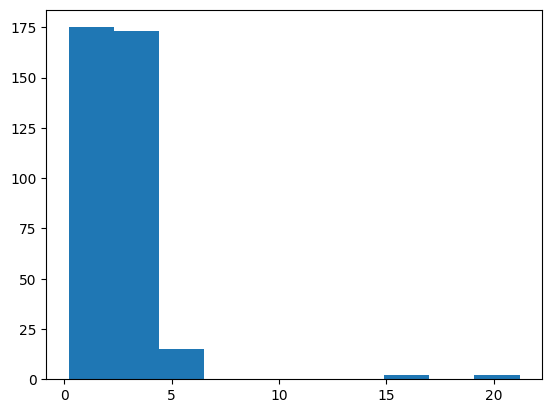

In [133]:
median_v2 = np.median(v2, axis=0)
dists_median = paired_distances(v2, np.repeat(median_v2.reshape((1, 2)), v2.shape[0], axis=0))
_ = plt.hist(dists_median)

There seems to be a few points with Euclidean distance much further away from the mean than all others&nbsp;&mdash;&nbsp;their
distance to the median is larger than 10.

In [134]:
process_names_clus["outlying"] = dists_median > 10.

In [135]:
%%sql
select *
from process_names_clus
where outlying
order by tokens

,name,num_processes,tokens,cluster,label,outlying
0,find.exe,227,[find],-1,Unlabelled,True
1,findstr.exe,17,"[find, str]",-1,Unlabelled,True
2,notepad.exe,84,[notepad],-1,Unlabelled,True
3,notepad++.exe,7,"[notepad, ++]",-1,Unlabelled,True


These points were already tagged as outliers from the clustering,
and we see now that they each respectively belong to their own equivalence class.

CPU times: user 5.19 s, sys: 195 ms, total: 5.39 s
Wall time: 6.51 s


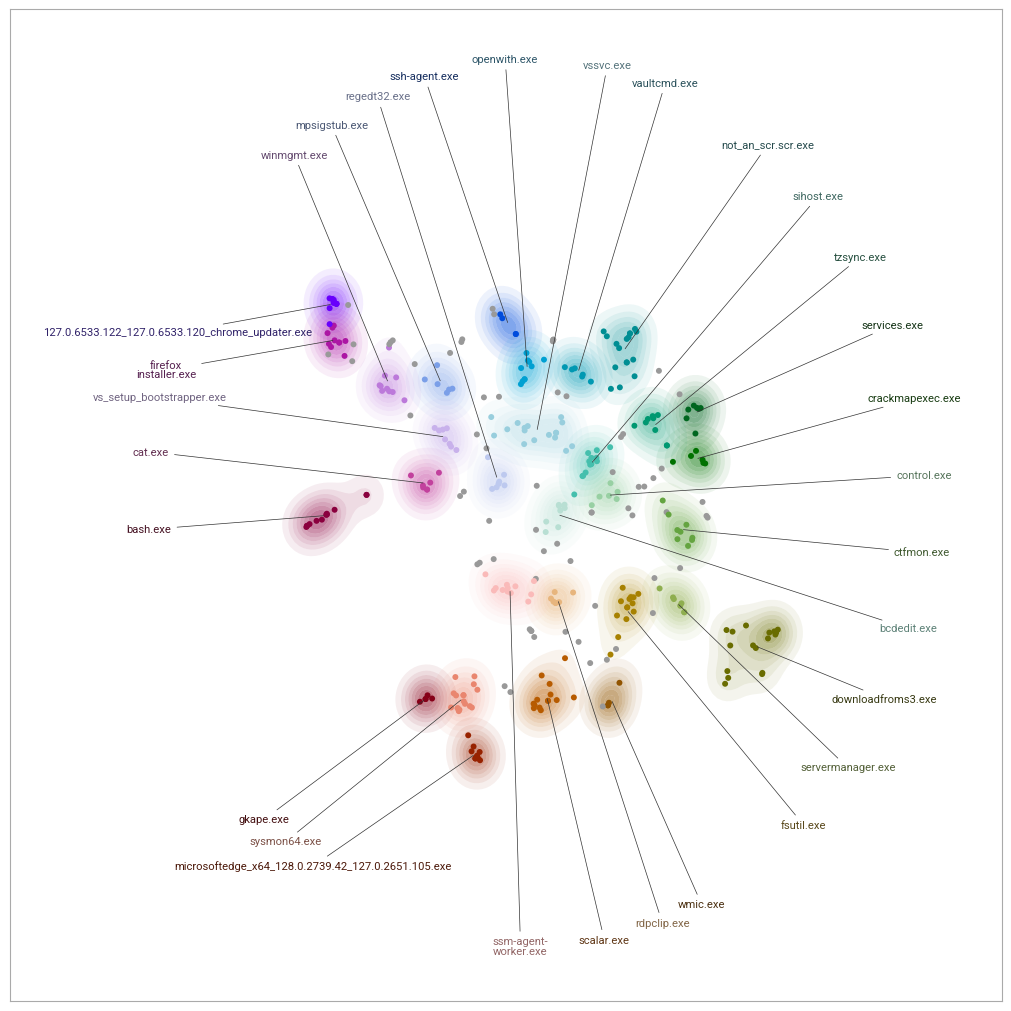

In [136]:
%%time
is_mapped = ~process_names_clus["outlying"]
_ = dmp.create_plot(v2[is_mapped], process_names_clus["label"].loc[is_mapped])

Let's look now at the data making up each of these clusters in turn.
Whenever we encounter non-singleton equivalence classes,
we edit the `ALIASES` dictionary.

In [137]:
process_names_clus["tokens"] = process_names_clus["tokens"].map(list)
names_x_cluster = {c: group for c, group in process_names_clus.groupby("cluster")}

In [151]:
label2c = {label: c for label, c in process_names_clus[["label", "cluster"]].drop_duplicates().itertuples(index=False)}
label2c

{'sihost.exe': 28,
 'wmic.exe': 10,
 'vs_setup_bootstrapper.exe': 17,
 'vssvc.exe': 27,
 '127.0.6533.122_127.0.6533.120_chrome_updater.exe': 2,
 'downloadfroms3.exe': 1,
 'microsoftedge_x64_128.0.2739.42_127.0.2651.105.exe': 4,
 'ssm-agent-worker.exe': 16,
 'firefox installer.exe': 3,
 'ctfmon.exe': 22,
 'bash.exe': 0,
 'fsutil.exe': 13,
 'vaultcmd.exe': 20,
 'Unlabelled': -1,
 'regedt32.exe': 18,
 'sysmon64.exe': 5,
 'rdpclip.exe': 15,
 'winmgmt.exe': 8,
 'tzsync.exe': 24,
 'not_an_scr.scr.exe': 11,
 'openwith.exe': 21,
 'control.exe': 26,
 'mpsigstub.exe': 7,
 'cat.exe': 14,
 'scalar.exe': 9,
 'services.exe': 23,
 'servermanager.exe': 12,
 'bcdedit.exe': 29,
 'crackmapexec.exe': 25,
 'ssh-agent.exe': 19,
 'gkape.exe': 6}

In [189]:
def show_clusters(*n):
    with pd.option_context("display.max_rows", None, "display.max_colWidth", None):
        display(pd.concat([names_x_cluster[label2c.get(i) or i] for i in n]).sort_values("tokens").drop(columns="outlying"))

In [190]:
show_clusters(-1)

,name,num_processes,tokens,cluster,label
266,f3d204_webbrowserpassview.exe,3,"[04_, web, browser, pass, ew]",-1,Unlabelled
88,calc.exe,46,[al],-1,Unlabelled
325,visualstudiosetup.exe,1,"[al, st, setup]",-1,Unlabelled
122,amazon-ssm-agent.exe,18,"[am, on, ssm-agent]",-1,Unlabelled
114,attrib.exe,20,"[att, ri]",-1,Unlabelled
91,schtasks.exe,44,"[ch, task]",-1,Unlabelled
21,chrome.exe,1405,[chrome],-1,Unlabelled
203,chromesetup.exe,6,"[chrome, setup]",-1,Unlabelled
18,cleanmgr.exe,1533,"[clean, mg]",-1,Unlabelled
356,cygwin-console-helper.exe,1,"[cyg, win, cons, le-, hel, per]",-1,Unlabelled


Here, the `t1036.003_masquerading*` monikers contain MITRE tactic metadata tagging.
There is thus no point in bringing them to a non-trivial equivalence class.

In [296]:
for name in process_names["name"]:
    if name.endswith("webbrowserpassview.exe"):
        ALIASES[name] = "webbrowserpassview.exe"
ALIASES

{'explorerr.exe': 'explorerR',
 'explorerr1.exe': 'explorerR',
 'explorerr4.exe': 'explorerR',
 'explorerr3.exe': 'explorerR',
 'explorerr2.exe': 'explorerR',
 'python.exe': 'python.exe',
 'python-3.12.5-amd64.exe': 'python.exe',
 'python-3.12.6-amd64.exe': 'python.exe',
 'pythonw.exe': 'python.exe',
 'f3d204_webbrowserpassview.exe': 'webbrowserpassview.exe'}

In [297]:
show_clusters(0)

,name,num_processes,tokens,cluster,label
217,arp.exe,5,[arp],0,bash.exe
14,bash.exe,1808,"[ba, sh]",0,bash.exe
230,git-2.46.0-64-bit.tmp.exe,4,"[git-, .46.0-64-bit.tmp]",0,bash.exe
304,git-2.46.0-64-bit.tmp,2,"[git-, .46.0-64-bit.tmp]",0,bash.exe
199,git-2.46.0-64-bit.exe,6,"[git-, 2.46.0-64-bit]",0,bash.exe
349,git-bash.exe,1,"[git-, ba, sh]",0,bash.exe
303,git-remote-https.exe,2,"[git-, remot]",0,bash.exe
61,net.exe,121,[net],0,bash.exe
62,net1.exe,110,[net],0,bash.exe
94,netsh.exe,40,"[net, sh]",0,bash.exe


From Windows documentation, `net1.exe` and `net.exe` are the same notional executable.
The `git-<VERSION>-64-bit.*` all look like they belong to an installation pipeline.
Although I don't believe we would find many more versions of this installation in the dataset,
let's deversion each of them for the principle.

In [298]:
ALIASES["net1.exe"] = "net.exe"
for name in process_names["name"]:
    if m := re.match(r"git-[.0-9]+-64-bit(?P<suffix>(\.tmp)?(\.exe)?)", name):
        ALIASES[name] = f"git-64-bit{m.group("suffix")}"
ALIASES

{'explorerr.exe': 'explorerR',
 'explorerr1.exe': 'explorerR',
 'explorerr4.exe': 'explorerR',
 'explorerr3.exe': 'explorerR',
 'explorerr2.exe': 'explorerR',
 'python.exe': 'python.exe',
 'python-3.12.5-amd64.exe': 'python.exe',
 'python-3.12.6-amd64.exe': 'python.exe',
 'pythonw.exe': 'python.exe',
 'f3d204_webbrowserpassview.exe': 'webbrowserpassview.exe',
 'net1.exe': 'net.exe',
 'git-2.46.0-64-bit.exe': 'git-64-bit.exe',
 'git-2.46.0-64-bit.tmp.exe': 'git-64-bit.tmp.exe',
 'git-2.46.0-64-bit.tmp': 'git-64-bit.tmp'}

In [299]:
show_clusters(1)

,name,num_processes,tokens,cluster,label
188,backgrounddownload.exe,7,"[background, download]",1,downloadfroms3.exe
13,backgroundtaskhost.exe,2021,"[background, taskhost]",1,downloadfroms3.exe
267,download.exe,3,[download],1,downloadfroms3.exe
111,downloadfroms3.exe,22,"[download, ms]",1,downloadfroms3.exe
10,msedge.exe,5619,[ms],1,downloadfroms3.exe
92,msiexec.exe,42,[ms],1,downloadfroms3.exe
95,mshta.exe,40,[ms],1,downloadfroms3.exe
178,msbuild.exe,8,"[ms, build]",1,downloadfroms3.exe
9,mscorsvw.exe,5895,"[ms, vw]",1,downloadfroms3.exe
329,sessionmsg.exe,1,"[session, ms]",1,downloadfroms3.exe


In [300]:
show_clusters(2)

,name,num_processes,tokens,cluster,label
365,127.0.6533.122_127.0.6533.120_chrome_updater.exe,1,"[127.0.6533.12, 2_127.0, chrome_, updater]",2,127.0.6533.122_127.0.6533.120_chrome_updater.exe
366,127.0.6533.120_chrome_installer.exe,1,"[127.0.6533.12, chrome_, installer]",2,127.0.6533.122_127.0.6533.120_chrome_updater.exe
270,128.0.6613.119_128.0.6613.114_chrome_updater.exe,3,"[128.0.6613, 128.0.6613, chrome_, updater]",2,127.0.6533.122_127.0.6533.120_chrome_updater.exe
361,128.0.6613.137_128.0.6613.120_chrome_updater.exe,1,"[128.0.6613, 128.0.6613.120_, chrome_, updater]",2,127.0.6533.122_127.0.6533.120_chrome_updater.exe
362,128.0.6613.121_128.0.6613.120_chrome_updater.exe,1,"[128.0.6613, 128.0.6613.120_, chrome_, updater]",2,127.0.6533.122_127.0.6533.120_chrome_updater.exe
316,128.0.6613.138_128.0.6613.121_chrome_updater.exe,2,"[128.0.6613, 138_128.0.6613.1, chrome_, updater]",2,127.0.6533.122_127.0.6533.120_chrome_updater.exe
360,128.0.6613.138_128.0.6613.137_chrome_updater.exe,1,"[128.0.6613, 138_128.0.6613.1, chrome_, updater]",2,127.0.6533.122_127.0.6533.120_chrome_updater.exe
364,128.0.6613.114_128.0.6613.86_chrome_updater.exe,1,"[128.0.6613.114_, 128.0.6613.86_, chrome_, updater]",2,127.0.6533.122_127.0.6533.120_chrome_updater.exe
317,128.0.6613.120_128.0.6613.119_chrome_updater.exe,2,"[128.0.6613.120_, 128.0.6613, chrome_, updater]",2,127.0.6533.122_127.0.6533.120_chrome_updater.exe
359,128.0.6613.86_128.0.6613.85_chrome_updater.exe,1,"[128.0.6613.86_, 128.0.6613, 85_chrome_, updater]",2,127.0.6533.122_127.0.6533.120_chrome_updater.exe


This one is interesting:
we see process name `127.0.6533.120_chrome_installer.exe`,
as well as a bunch of versioned Chrome updaters.
I sense that the neighbouring cluster,
labeled `firefox installer.exe`,
contains further versioned instances of `*chrome_installer.exe`.
Let's unpack both clusters together.

In [301]:
show_clusters(2, "firefox installer.exe")

,name,num_processes,tokens,cluster,label
365,127.0.6533.122_127.0.6533.120_chrome_updater.exe,1,"[127.0.6533.12, 2_127.0, chrome_, updater]",2,127.0.6533.122_127.0.6533.120_chrome_updater.exe
366,127.0.6533.120_chrome_installer.exe,1,"[127.0.6533.12, chrome_, installer]",2,127.0.6533.122_127.0.6533.120_chrome_updater.exe
270,128.0.6613.119_128.0.6613.114_chrome_updater.exe,3,"[128.0.6613, 128.0.6613, chrome_, updater]",2,127.0.6533.122_127.0.6533.120_chrome_updater.exe
361,128.0.6613.137_128.0.6613.120_chrome_updater.exe,1,"[128.0.6613, 128.0.6613.120_, chrome_, updater]",2,127.0.6533.122_127.0.6533.120_chrome_updater.exe
362,128.0.6613.121_128.0.6613.120_chrome_updater.exe,1,"[128.0.6613, 128.0.6613.120_, chrome_, updater]",2,127.0.6533.122_127.0.6533.120_chrome_updater.exe
316,128.0.6613.138_128.0.6613.121_chrome_updater.exe,2,"[128.0.6613, 138_128.0.6613.1, chrome_, updater]",2,127.0.6533.122_127.0.6533.120_chrome_updater.exe
360,128.0.6613.138_128.0.6613.137_chrome_updater.exe,1,"[128.0.6613, 138_128.0.6613.1, chrome_, updater]",2,127.0.6533.122_127.0.6533.120_chrome_updater.exe
315,128.0.6613.85_chrome_installer.exe,2,"[128.0.6613, 85_chrome_, installer]",3,firefox installer.exe
364,128.0.6613.114_128.0.6613.86_chrome_updater.exe,1,"[128.0.6613.114_, 128.0.6613.86_, chrome_, updater]",2,127.0.6533.122_127.0.6533.120_chrome_updater.exe
363,128.0.6613.114_chrome_installer.exe,1,"[128.0.6613.114_, chrome_, installer]",3,firefox installer.exe


My hypothesis was right.
We now have non-trivial equivalence classes for `*chrome_update.exe`,
`*chrome_installer.exe`,
and `npp.*.installer.x64.exe`.

In [302]:
for suffix in ["chrome_installer.exe", "chrome_updater.exe"]:
    for name in process_names["name"]:
        if name.endswith(suffix):
            ALIASES[name] = suffix
for name in process_names["name"]:
    if re.match(r"npp\.[.0-9]+\.installer\.x64\.exe", name):
        ALIASES[name] = "npp.installer.x64.exe"
ALIASES

{'explorerr.exe': 'explorerR',
 'explorerr1.exe': 'explorerR',
 'explorerr4.exe': 'explorerR',
 'explorerr3.exe': 'explorerR',
 'explorerr2.exe': 'explorerR',
 'python.exe': 'python.exe',
 'python-3.12.5-amd64.exe': 'python.exe',
 'python-3.12.6-amd64.exe': 'python.exe',
 'pythonw.exe': 'python.exe',
 'f3d204_webbrowserpassview.exe': 'webbrowserpassview.exe',
 'net1.exe': 'net.exe',
 'git-2.46.0-64-bit.exe': 'git-64-bit.exe',
 'git-2.46.0-64-bit.tmp.exe': 'git-64-bit.tmp.exe',
 'git-2.46.0-64-bit.tmp': 'git-64-bit.tmp',
 '128.0.6613.85_chrome_installer.exe': 'chrome_installer.exe',
 '128.0.6613.114_chrome_installer.exe': 'chrome_installer.exe',
 '127.0.6533.120_chrome_installer.exe': 'chrome_installer.exe',
 '128.0.6613.119_128.0.6613.114_chrome_updater.exe': 'chrome_updater.exe',
 '128.0.6613.138_128.0.6613.121_chrome_updater.exe': 'chrome_updater.exe',
 '128.0.6613.120_128.0.6613.119_chrome_updater.exe': 'chrome_updater.exe',
 '128.0.6613.86_128.0.6613.85_chrome_updater.exe': 'chrome

In [303]:
show_clusters(4)

,name,num_processes,tokens,cluster,label
228,microsoftedge_x64_129.0.2792.52_128.0.2739.79.exe,4,"[microsoftedge, _x64_12, 79, _128.0.2739.79]",4,microsoftedge_x64_128.0.2739.42_127.0.2651.105.exe
169,microsoftedge_x64_128.0.2739.54_128.0.2739.42.exe,10,"[microsoftedge, _x64_12, 8.0.2739.54]",4,microsoftedge_x64_128.0.2739.42_127.0.2651.105.exe
296,microsoftedge_x64_128.0.2739.54.exe,2,"[microsoftedge, _x64_12, 8.0.2739.54]",4,microsoftedge_x64_128.0.2739.42_127.0.2651.105.exe
165,microsoftedge_x64_128.0.2739.42_127.0.2651.105.exe,11,"[microsoftedge, _x64_128.0.2739, 2_127.0]",4,microsoftedge_x64_128.0.2739.42_127.0.2651.105.exe
164,microsoftedge_x64_128.0.2739.63_128.0.2739.54.exe,11,"[microsoftedge, _x64_128.0.2739, 63, _128.0.2739.54]",4,microsoftedge_x64_128.0.2739.42_127.0.2651.105.exe
154,microsoftedge_x64_128.0.2739.67_128.0.2739.63.exe,12,"[microsoftedge, _x64_128.0.2739, 67, _128.0.2739.63]",4,microsoftedge_x64_128.0.2739.42_127.0.2651.105.exe
153,microsoftedge_x64_128.0.2739.79_128.0.2739.67.exe,12,"[microsoftedge, _x64_128.0.2739, 79, _128.0.2739.67]",4,microsoftedge_x64_128.0.2739.42_127.0.2651.105.exe
6,microsoftedgeupdate.exe,7902,"[microsoftedge, update]",4,microsoftedge_x64_128.0.2739.42_127.0.2651.105.exe
163,microsoftedgeupdatebroker.exe,11,"[microsoftedge, update, bro, ker]",4,microsoftedge_x64_128.0.2739.42_127.0.2651.105.exe
105,microsoftedgeupdatecomregistershell64.exe,27,"[microsoftedge, update, com, regist, shell, 64]",4,microsoftedge_x64_128.0.2739.42_127.0.2651.105.exe


In [304]:
show_clusters(4)

,name,num_processes,tokens,cluster,label
228,microsoftedge_x64_129.0.2792.52_128.0.2739.79.exe,4,"[microsoftedge, _x64_12, 79, _128.0.2739.79]",4,microsoftedge_x64_128.0.2739.42_127.0.2651.105.exe
169,microsoftedge_x64_128.0.2739.54_128.0.2739.42.exe,10,"[microsoftedge, _x64_12, 8.0.2739.54]",4,microsoftedge_x64_128.0.2739.42_127.0.2651.105.exe
296,microsoftedge_x64_128.0.2739.54.exe,2,"[microsoftedge, _x64_12, 8.0.2739.54]",4,microsoftedge_x64_128.0.2739.42_127.0.2651.105.exe
165,microsoftedge_x64_128.0.2739.42_127.0.2651.105.exe,11,"[microsoftedge, _x64_128.0.2739, 2_127.0]",4,microsoftedge_x64_128.0.2739.42_127.0.2651.105.exe
164,microsoftedge_x64_128.0.2739.63_128.0.2739.54.exe,11,"[microsoftedge, _x64_128.0.2739, 63, _128.0.2739.54]",4,microsoftedge_x64_128.0.2739.42_127.0.2651.105.exe
154,microsoftedge_x64_128.0.2739.67_128.0.2739.63.exe,12,"[microsoftedge, _x64_128.0.2739, 67, _128.0.2739.63]",4,microsoftedge_x64_128.0.2739.42_127.0.2651.105.exe
153,microsoftedge_x64_128.0.2739.79_128.0.2739.67.exe,12,"[microsoftedge, _x64_128.0.2739, 79, _128.0.2739.67]",4,microsoftedge_x64_128.0.2739.42_127.0.2651.105.exe
6,microsoftedgeupdate.exe,7902,"[microsoftedge, update]",4,microsoftedge_x64_128.0.2739.42_127.0.2651.105.exe
163,microsoftedgeupdatebroker.exe,11,"[microsoftedge, update, bro, ker]",4,microsoftedge_x64_128.0.2739.42_127.0.2651.105.exe
105,microsoftedgeupdatecomregistershell64.exe,27,"[microsoftedge, update, com, regist, shell, 64]",4,microsoftedge_x64_128.0.2739.42_127.0.2651.105.exe


In [305]:
for name in process_names["name"]:
    if name.startswith("microsoftedge_x64_"):
        ALIASES[name] = "microsoftedge_x64.exe"
    if name.startswith("microsoftedgeupdatesetup_x86_"):
        ALIASES[name] = "microsoftedgeupdatesetup_x86.exe"
ALIASES

{'explorerr.exe': 'explorerR',
 'explorerr1.exe': 'explorerR',
 'explorerr4.exe': 'explorerR',
 'explorerr3.exe': 'explorerR',
 'explorerr2.exe': 'explorerR',
 'python.exe': 'python.exe',
 'python-3.12.5-amd64.exe': 'python.exe',
 'python-3.12.6-amd64.exe': 'python.exe',
 'pythonw.exe': 'python.exe',
 'f3d204_webbrowserpassview.exe': 'webbrowserpassview.exe',
 'net1.exe': 'net.exe',
 'git-2.46.0-64-bit.exe': 'git-64-bit.exe',
 'git-2.46.0-64-bit.tmp.exe': 'git-64-bit.tmp.exe',
 'git-2.46.0-64-bit.tmp': 'git-64-bit.tmp',
 '128.0.6613.85_chrome_installer.exe': 'chrome_installer.exe',
 '128.0.6613.114_chrome_installer.exe': 'chrome_installer.exe',
 '127.0.6533.120_chrome_installer.exe': 'chrome_installer.exe',
 '128.0.6613.119_128.0.6613.114_chrome_updater.exe': 'chrome_updater.exe',
 '128.0.6613.138_128.0.6613.121_chrome_updater.exe': 'chrome_updater.exe',
 '128.0.6613.120_128.0.6613.119_chrome_updater.exe': 'chrome_updater.exe',
 '128.0.6613.86_128.0.6613.85_chrome_updater.exe': 'chrome

In [306]:
show_clusters(5)

,name,num_processes,tokens,cluster,label
103,conda.exe,29,[conda],5,sysmon64.exe
144,_conda.exe,14,[conda],5,sysmon64.exe
155,expr.exe,12,[exp],5,sysmon64.exe
26,git.exe,1111,[git],5,sysmon64.exe
348,gitlab-runner-windows-amd64.exe,1,"[git, ab, runner, -windows-, am, 64]",5,sysmon64.exe
239,akagi64.exe,4,"[ka, 64]",5,sysmon64.exe
294,mintty.exe,2,[min],5,sysmon64.exe
295,miniconda3-latest-windows-x86_64.exe,2,"[min, conda, test, -windows-, x86_, 64]",5,sysmon64.exe
336,procexp64.exe,1,"[proc, exp, 64]",5,sysmon64.exe
335,procmon64.exe,1,"[proc, mon, 64]",5,sysmon64.exe


Although `sysmon64.exe` is likely just a 64-bit Intel rebuild of `sysmon.exe`,
let's let the both of them fly in distinct equivalence classes,
as low-level behaviour of 32-bit and 64-bit executables on Windows can generate significantly distinct events.

In [307]:
show_clusters(6)

,name,num_processes,tokens,cluster,label
195,kali.exe,6,[ka],6,gkape.exe
198,gkape.exe,6,"[ka, pe]",6,gkape.exe
299,kape.exe,2,"[ka, pe]",6,gkape.exe
179,mimikatz.exe,8,"[mimi, ka]",6,gkape.exe
186,pet.exe,7,[pe],6,gkape.exe


In [308]:
show_clusters(7)

,name,num_processes,tokens,cluster,label
261,mpsigstub.exe,3,"[mp, sig, st, ub]",7,mpsigstub.exe
334,rawtostdview.exe,1,"[rawto, st, ew]",7,mpsigstub.exe
191,setup-stub.exe,6,"[setup-st, ub]",7,mpsigstub.exe
47,tstheme.exe,232,"[st, me]",7,mpsigstub.exe
204,ubuntu.exe,5,"[ub, ntu]",7,mpsigstub.exe
225,rubeus.exe,4,"[ub, us]",7,mpsigstub.exe


In [309]:
show_clusters(8)

,name,num_processes,tokens,cluster,label
78,ie4uinit.exe,66,[ini],8,winmgmt.exe
32,setup.exe,762,[setup],8,winmgmt.exe
326,virtualbox.exe,1,[virtualbox],8,winmgmt.exe
278,virtualbox-7.0.20-163906-win.exe,2,"[virtualbox, 63, win]",8,winmgmt.exe
116,wininit.exe,18,"[win, ini]",8,winmgmt.exe
54,winlogon.exe,185,"[win, logon]",8,winmgmt.exe
320,winmgmt.exe,1,"[win, mg]",8,winmgmt.exe
189,wincreds.exe,6,"[win, re]",8,winmgmt.exe
274,winsdksetup.exe,2,"[win, setup]",8,winmgmt.exe
258,qwinsta.exe,3,"[win, st]",8,winmgmt.exe


The versioned variant of `virtualbox*` is likely an installer,
whereas `virtualbox.exe` is the installed program.

In [310]:
for name in process_names["name"]:
    if re.match(r"virtualbox[-.0-9]+-win.exe", name):
        ALIASES[name] = "virtualbox-installer.exe"
ALIASES

{'explorerr.exe': 'explorerR',
 'explorerr1.exe': 'explorerR',
 'explorerr4.exe': 'explorerR',
 'explorerr3.exe': 'explorerR',
 'explorerr2.exe': 'explorerR',
 'python.exe': 'python.exe',
 'python-3.12.5-amd64.exe': 'python.exe',
 'python-3.12.6-amd64.exe': 'python.exe',
 'pythonw.exe': 'python.exe',
 'f3d204_webbrowserpassview.exe': 'webbrowserpassview.exe',
 'net1.exe': 'net.exe',
 'git-2.46.0-64-bit.exe': 'git-64-bit.exe',
 'git-2.46.0-64-bit.tmp.exe': 'git-64-bit.tmp.exe',
 'git-2.46.0-64-bit.tmp': 'git-64-bit.tmp',
 '128.0.6613.85_chrome_installer.exe': 'chrome_installer.exe',
 '128.0.6613.114_chrome_installer.exe': 'chrome_installer.exe',
 '127.0.6533.120_chrome_installer.exe': 'chrome_installer.exe',
 '128.0.6613.119_128.0.6613.114_chrome_updater.exe': 'chrome_updater.exe',
 '128.0.6613.138_128.0.6613.121_chrome_updater.exe': 'chrome_updater.exe',
 '128.0.6613.120_128.0.6613.119_chrome_updater.exe': 'chrome_updater.exe',
 '128.0.6613.86_128.0.6613.85_chrome_updater.exe': 'chrome

In [311]:
show_clusters(9)

,name,num_processes,tokens,cluster,label
82,dxgiadaptercache.exe,63,"[adap, ter, ca, ch]",9,scalar.exe
192,scalar.exe,6,[ca],9,scalar.exe
340,ncat.exe,1,[ca],9,scalar.exe
132,icacls.exe,16,"[ca, cls]",9,scalar.exe
102,pcaui.exe,29,"[ca, ui]",9,scalar.exe
59,code.exe,133,[code],9,scalar.exe
216,codesetup-stable-4849ca9bdf9666755eb463db297b69e5385090e3.exe,5,"[code, setup-st, ab, le-, ca, df, 67, 63, db, 97b69e5385090e3]",9,scalar.exe
215,codesetup-stable-4849ca9bdf9666755eb463db297b69e5385090e3.tmp.exe,5,"[code, setup-st, ab, le-, ca, df, 67, 63, db, 97b69e5385090e3, tmp]",9,scalar.exe
182,code-tunnel.exe,8,"[code, unne]",9,scalar.exe
352,duckdb.exe,1,[db],9,scalar.exe


In [312]:
for name in process_names["name"]:
    if m := re.match(r"codesetup-stable-[0-9a-f]+(?P<suffix>(\.tmp)?(\.exe)?)", name):
        ALIASES[name] = f"codesetup-stable{m.group('suffix')}"
ALIASES

{'explorerr.exe': 'explorerR',
 'explorerr1.exe': 'explorerR',
 'explorerr4.exe': 'explorerR',
 'explorerr3.exe': 'explorerR',
 'explorerr2.exe': 'explorerR',
 'python.exe': 'python.exe',
 'python-3.12.5-amd64.exe': 'python.exe',
 'python-3.12.6-amd64.exe': 'python.exe',
 'pythonw.exe': 'python.exe',
 'f3d204_webbrowserpassview.exe': 'webbrowserpassview.exe',
 'net1.exe': 'net.exe',
 'git-2.46.0-64-bit.exe': 'git-64-bit.exe',
 'git-2.46.0-64-bit.tmp.exe': 'git-64-bit.tmp.exe',
 'git-2.46.0-64-bit.tmp': 'git-64-bit.tmp',
 '128.0.6613.85_chrome_installer.exe': 'chrome_installer.exe',
 '128.0.6613.114_chrome_installer.exe': 'chrome_installer.exe',
 '127.0.6533.120_chrome_installer.exe': 'chrome_installer.exe',
 '128.0.6613.119_128.0.6613.114_chrome_updater.exe': 'chrome_updater.exe',
 '128.0.6613.138_128.0.6613.121_chrome_updater.exe': 'chrome_updater.exe',
 '128.0.6613.120_128.0.6613.119_chrome_updater.exe': 'chrome_updater.exe',
 '128.0.6613.86_128.0.6613.85_chrome_updater.exe': 'chrome

In [313]:
show_clusters(10)

,name,num_processes,tokens,cluster,label
358,certsrv.exe,1,"[cert, rv]",10,wmic.exe
1,wmic.exe,283125,[wmi],10,wmic.exe
25,wmiprvse.exe,1155,[wmi],10,wmic.exe
184,wmiapsrv.exe,7,"[wmi, aps, rv]",10,wmic.exe


In [314]:
show_clusters(11)

,name,num_processes,tokens,cluster,label
260,not_an_scr.scr.exe,3,"[_a, scr, scr]",11,not_an_scr.scr.exe
202,chxsmartscreen.exe,6,"[ch, sm, art, scr, en]",11,not_an_scr.scr.exe
357,configure-smremoting.exe,1,"[config, ure, sm, remot, ing]",11,not_an_scr.scr.exe
43,disksnapshot.exe,271,"[disk, aps]",11,not_an_scr.scr.exe
128,diskpart.exe,17,"[disk, art]",11,not_an_scr.scr.exe
212,gpresult.exe,5,"[gp, re, ult]",11,not_an_scr.scr.exe
180,gpscript.exe,8,"[gp, scr, ip]",11,not_an_scr.scr.exe
152,pip.exe,12,[ip],11,not_an_scr.scr.exe
107,ipconfig.exe,25,"[ip, config]",11,not_an_scr.scr.exe
333,regasm.exe,1,"[re, sm]",11,not_an_scr.scr.exe


In [315]:
show_clusters(12)

,name,num_processes,tokens,cluster,label
85,chrmstp.exe,56,"[ch, mst]",12,servermanager.exe
170,cmstp.exe,10,[mst],12,servermanager.exe
293,mstsc.exe,2,[mst],12,servermanager.exe
283,servermanager.exe,2,[servermanager],12,servermanager.exe
72,servermanagerlauncher.exe,74,"[servermanager, ch, er]",12,servermanager.exe
86,whoami.exe,49,"[wh, ami]",12,servermanager.exe
129,which.exe,16,"[wh, ch]",12,servermanager.exe


In [316]:
show_clusters(13)

,name,num_processes,tokens,cluster,label
313,893687_t1027.004_dynamiccompile.exe,2,"[36, t10, 04_, ami, comp, il]",13,fsutil.exe
58,certutil.exe,144,"[cert, ut, il]",13,fsutil.exe
15,compattelrunner.exe,1666,"[comp, att, runner]",13,fsutil.exe
166,wevtutil.exe,10,"[ev, ut, il]",13,fsutil.exe
232,forfiles.exe,4,"[fo, il]",13,fsutil.exe
162,mofcomp.exe,11,[mofcomp],13,fsutil.exe
342,mofcompiler.exe,1,"[mofcomp, il, er]",13,fsutil.exe
259,pnputil.exe,3,"[nput, il]",13,fsutil.exe
110,geckodriver.exe,22,"[ri, ver]",13,fsutil.exe
149,searchfilterhost.exe,12,"[search, il, ter, host]",13,fsutil.exe


Item `893687_t1027.004_dynamiccompile.exe` is tagged with what looks like MITRE tactic metadata.
Let's leave it as it is.

In [317]:
show_clusters(14)

,name,num_processes,tokens,cluster,label
311,cat.exe,2,[at],14,cat.exe
312,at.exe,2,[at],14,cat.exe
57,cygpath.exe,145,"[cyg, at]",14,cat.exe
292,netstat.exe,2,"[net, st, at]",14,cat.exe
288,nyancat.exe,2,"[ny, anc, at]",14,cat.exe
194,perfwatson2.exe,6,"[per, at, on]",14,cat.exe
321,winlogbeat.exe,1,"[winlog, at]",14,cat.exe


In [318]:
show_clusters(15)

,name,num_processes,tokens,cluster,label
56,rdpclip.exe,145,[cli],15,rdpclip.exe
157,clip.exe,12,[cli],15,rdpclip.exe
28,wsqmcons.exe,980,[cons],15,rdpclip.exe
52,consent.exe,198,"[cons, ent]",15,rdpclip.exe
306,eventvwr.exe,2,"[ev, ent, vw]",15,rdpclip.exe
37,sihclient.exe,319,"[sih, cli, ent]",15,rdpclip.exe
31,usoclient.exe,883,"[usoc, ent]",15,rdpclip.exe


In [319]:
show_clusters(16)

,name,num_processes,tokens,cluster,label
76,atbroker.exe,71,"[at, bro, ker]",16,ssm-agent-worker.exe
353,dockerd.exe,1,"[doc, ker]",16,ssm-agent-worker.exe
318,wordpad.exe,1,[ord],16,ssm-agent-worker.exe
310,credentialuibroker.exe,2,"[re, ent, al, ui, bro, ker]",16,ssm-agent-worker.exe
35,ssm-document-worker.exe,350,"[ssm-, doc, um, ent, wor, ker]",16,ssm-agent-worker.exe
221,ssm-session-worker.exe,4,"[ssm-, session, wor, ker]",16,ssm-agent-worker.exe
118,ssm-agent-worker.exe,18,"[ssm-agent, wor, ker]",16,ssm-agent-worker.exe
131,systemsettings.exe,16,[systemsettings],16,ssm-agent-worker.exe
168,systemsettingsadminflows.exe,10,"[systemsettings, admin]",16,ssm-agent-worker.exe
250,systemsettingsbroker.exe,3,"[systemsettings, bro, ker]",16,ssm-agent-worker.exe


In [320]:
show_clusters(17)

,name,num_processes,tokens,cluster,label
147,fodhelper.exe,13,"[fo, hel, per]",17,vs_setup_bootstrapper.exe
346,hello.exe,1,[hel],17,vs_setup_bootstrapper.exe
2,mergehelper.exe,122882,"[hel, per]",17,vs_setup_bootstrapper.exe
142,identity_helper.exe,14,"[identity, hel, per]",17,vs_setup_bootstrapper.exe
308,dsadd.exe,2,[sad],17,vs_setup_bootstrapper.exe
172,systeminfo.exe,9,"[system, inf]",17,vs_setup_bootstrapper.exe
140,systempropertiesadvanced.exe,14,"[system, pro, per, ti, sad, anc]",17,vs_setup_bootstrapper.exe
277,vs_setup_bootstrapper.exe,2,"[vs_, setup_, boot, stra, per]",17,vs_setup_bootstrapper.exe


In [321]:
show_clusters(18)

,name,num_processes,tokens,cluster,label
167,w32tm.exe,10,"[32, tm]",18,regedt32.exe
126,regedit.exe,17,[reged],18,regedt32.exe
332,regedt32.exe,1,"[reged, 32]",18,regedt32.exe
226,regsvcs.exe,4,[regsv],18,regedt32.exe
101,regsvr32.exe,30,"[regsv, 32]",18,regedt32.exe
224,runas.exe,4,"[run, as]",18,regedt32.exe
22,rundll32.exe,1245,"[run, dll, 32]",18,regedt32.exe


In [322]:
show_clusters(19)

,name,num_processes,tokens,cluster,label
276,wazuh-agent.exe,2,"[azu, -agent]",19,ssh-agent.exe
104,sshd.exe,27,[ssh],19,ssh-agent.exe
222,ssh.exe,4,[ssh],19,ssh-agent.exe
252,ssh-agent.exe,3,"[ssh, -agent]",19,ssh-agent.exe


In [323]:
show_clusters(20)

,name,num_processes,tokens,cluster,label
16,cmd.exe,1583,[cmd],20,vaultcmd.exe
269,cmdkey.exe,3,"[cmd, key]",20,vaultcmd.exe
307,dsmod.exe,2,"[ds, mod]",20,vaultcmd.exe
33,dsregcmd.exe,702,"[ds, re, cmd]",20,vaultcmd.exe
148,vaultcmd.exe,12,"[ult, cmd]",20,vaultcmd.exe
146,werfault.exe,13,"[wer, ult]",20,vaultcmd.exe


In [324]:
show_clusters(21)

,name,num_processes,tokens,cluster,label
309,curl.exe,2,[cur],21,openwith.exe
44,dstokenclean.exe,270,"[ds, ok, en, clean]",21,openwith.exe
106,openwith.exe,26,[en],21,openwith.exe
193,ping.exe,6,[ping],21,openwith.exe
135,pingsender.exe,15,"[ping, en, er]",21,openwith.exe
60,sed.exe,131,[se],21,openwith.exe
120,setspn.exe,18,[se],21,openwith.exe
93,securebootencodeuefi.exe,41,"[se, cur, boot, en, codeu]",21,openwith.exe
161,selenium-manager.exe,11,"[se, en, um, er]",21,openwith.exe
223,ssh-keygen.exe,4,"[ssh, key, en]",21,openwith.exe


In [325]:
show_clusters(22)

,name,num_processes,tokens,cluster,label
171,acmetaskmonitor.exe,10,"[ac, me, task, mon, tor]",22,ctfmon.exe
197,infdefaultinstall.exe,6,"[inf, default, install]",22,ctfmon.exe
196,installtaskmonitor.exe,6,"[install, task, mon, tor]",22,ctfmon.exe
70,ctfmon.exe,76,[mon],22,ctfmon.exe
12,ngen.exe,2171,[ngen],22,ctfmon.exe
27,ngentask.exe,1064,"[ngen, task]",22,ctfmon.exe
139,tasklist.exe,14,"[task, ist]",22,ctfmon.exe
160,taskmgr.exe,11,"[task, mg]",22,ctfmon.exe
280,uninstall.exe,2,"[un, install]",22,ctfmon.exe


In [326]:
show_clusters(23)

,name,num_processes,tokens,cluster,label
344,microsoft.activedirectory.webservices.exe,1,"[ac, ti, re, tor, web, service]",23,services.exe
65,ec2launch.exe,87,[ec2launch],23,services.exe
136,ec2launchservice.exe,15,"[ec2launch, service]",23,services.exe
81,elevation_service.exe,63,"[ev, ation, service]",23,services.exe
254,securityhealthservice.exe,3,"[securityhealth, service]",23,services.exe
121,services.exe,18,[service],23,services.exe
218,wslservice.exe,4,"[wsl, service]",23,services.exe


In [327]:
show_clusters(24)

,name,num_processes,tokens,cluster,label
158,azurearcsystray.exe,12,"[azu, re, sy, stra]",24,tzsync.exe
213,drvinst.exe,5,"[drv, inst]",24,tzsync.exe
343,mimidrv.sys.exe,1,"[mimi, drv, sy]",24,tzsync.exe
113,nc.exe,21,[nc],24,tzsync.exe
75,mobsync.exe,73,"[ob, sy, nc]",24,tzsync.exe
34,reg.exe,525,[re],24,tzsync.exe
55,cvtres.exe,147,[re],24,tzsync.exe
79,securityhealthsystray.exe,65,"[securityhealth, sy, stra]",24,tzsync.exe
89,tzsync.exe,45,"[tz, sy, nc]",24,tzsync.exe


In [328]:
show_clusters(25)

,name,num_processes,tokens,cluster,label
112,crackmapexec.exe,22,"[ac, map]",25,crackmapexec.exe
97,aws.exe,40,[aws],25,crackmapexec.exe
133,awsacpispcrreader.exe,16,"[aws, ac, re, er]",25,crackmapexec.exe
234,fltmc.exe,4,[tm],25,crackmapexec.exe
264,getmac.exe,3,"[tm, ac]",25,crackmapexec.exe
145,where.exe,13,"[wh, re]",25,crackmapexec.exe


In [329]:
show_clusters(26)

,name,num_processes,tokens,cluster,label
159,applicationframehost.exe,12,"[app, ation, fra, me, host]",26,control.exe
45,apphostregistrationverifier.exe,265,"[app, host, registr, ation, ver, er]",26,control.exe
201,control.exe,6,[control],26,control.exe
66,searchapp.exe,85,"[search, app]",26,control.exe
211,microsoft.servicehub.controller.exe,5,"[servicehub, control, er]",26,control.exe
46,wudfhost.exe,235,"[wu, df, host]",26,control.exe


In [330]:
show_clusters(27)

,name,num_processes,tokens,cluster,label
355,dfsrs.exe,1,[dfs],27,vssvc.exe
354,dfssvc.exe,1,"[dfs, svc]",27,vssvc.exe
74,textinputhost.exe,73,"[ex, ti, nput, host]",27,vssvc.exe
30,mpcmdrun.exe,920,"[mp, cmd, run]",27,vssvc.exe
109,quser.exe,23,"[qu, ser]",27,vssvc.exe
68,userinit.exe,80,"[ser, ini]",27,vssvc.exe
108,shellexperiencehost.exe,23,"[shell, ex, per, en, ce, host]",27,vssvc.exe
98,sppextcomobj.exe,33,"[spp, ex, com, ob]",27,vssvc.exe
11,sppsvc.exe,4085,"[spp, svc]",27,vssvc.exe
3,svchost.exe,15028,"[svc, host]",27,vssvc.exe


In [331]:
for name in process_names["name"]:
    if m := re.match(r"vscodeusersetup-x64-[.0-9]*(?P<suffix>(tmp\.)?exe)", name):
        ALIASES[name] = f"vscodeusersetup-x64.{m.group('suffix')}"
ALIASES

{'explorerr.exe': 'explorerR',
 'explorerr1.exe': 'explorerR',
 'explorerr4.exe': 'explorerR',
 'explorerr3.exe': 'explorerR',
 'explorerr2.exe': 'explorerR',
 'python.exe': 'python.exe',
 'python-3.12.5-amd64.exe': 'python.exe',
 'python-3.12.6-amd64.exe': 'python.exe',
 'pythonw.exe': 'python.exe',
 'f3d204_webbrowserpassview.exe': 'webbrowserpassview.exe',
 'net1.exe': 'net.exe',
 'git-2.46.0-64-bit.exe': 'git-64-bit.exe',
 'git-2.46.0-64-bit.tmp.exe': 'git-64-bit.tmp.exe',
 'git-2.46.0-64-bit.tmp': 'git-64-bit.tmp',
 '128.0.6613.85_chrome_installer.exe': 'chrome_installer.exe',
 '128.0.6613.114_chrome_installer.exe': 'chrome_installer.exe',
 '127.0.6533.120_chrome_installer.exe': 'chrome_installer.exe',
 '128.0.6613.119_128.0.6613.114_chrome_updater.exe': 'chrome_updater.exe',
 '128.0.6613.138_128.0.6613.121_chrome_updater.exe': 'chrome_updater.exe',
 '128.0.6613.120_128.0.6613.119_chrome_updater.exe': 'chrome_updater.exe',
 '128.0.6613.86_128.0.6613.85_chrome_updater.exe': 'chrome

In [332]:
show_clusters(28)

,name,num_processes,tokens,cluster,label
0,conhost.exe,1244024,"[con, host]",28,sihost.exe
257,rdrleakdiag.exe,3,[diag],28,sihost.exe
99,sdiagnhost.exe,33,"[diag, host]",28,sihost.exe
176,dism.exe,9,[dism],28,sihost.exe
17,dismhost.exe,1571,"[dism, host]",28,sihost.exe
29,dllhost.exe,971,"[dll, host]",28,sihost.exe
69,sihost.exe,77,[host],28,sihost.exe
305,ghosts.exe,2,[host],28,sihost.exe
96,hostname.exe,40,"[host, am]",28,sihost.exe
255,securityhealthhost.exe,3,"[securityhealth, host]",28,sihost.exe


In [333]:
show_clusters(29)

,name,num_processes,tokens,cluster,label
236,caldera.exe,4,"[al, de]",29,bcdedit.exe
238,am_delta.exe,4,"[am, de]",29,bcdedit.exe
298,ldifde.exe,2,[de],29,bcdedit.exe
237,bcdedit.exe,4,"[de, dit]",29,bcdedit.exe
87,defrag.exe,47,"[de, fra]",29,bcdedit.exe
143,auditpol.exe,14,[dit],29,bcdedit.exe
231,genvalobj.exe,4,"[env, al, ob]",29,bcdedit.exe
286,qualification_app.exe,2,"[qu, al, ation, app]",29,bcdedit.exe


Having looked at all process names and mapped their equivalence classes,
let's save this map to this repository.
Let's also tag every process instance with its process name equivalence class.
The name of this feature would be `process_class`.

In [336]:
Path("process_class.json").write_text(json.dumps(ALIASES, indent=2, sort_keys=True))
print(Path("process_class.json").read_text())

{
  "127.0.6533.120_chrome_installer.exe": "chrome_installer.exe",
  "127.0.6533.122_127.0.6533.120_chrome_updater.exe": "chrome_updater.exe",
  "128.0.6613.114_128.0.6613.86_chrome_updater.exe": "chrome_updater.exe",
  "128.0.6613.114_chrome_installer.exe": "chrome_installer.exe",
  "128.0.6613.119_128.0.6613.114_chrome_updater.exe": "chrome_updater.exe",
  "128.0.6613.120_128.0.6613.119_chrome_updater.exe": "chrome_updater.exe",
  "128.0.6613.121_128.0.6613.120_chrome_updater.exe": "chrome_updater.exe",
  "128.0.6613.137_128.0.6613.120_chrome_updater.exe": "chrome_updater.exe",
  "128.0.6613.138_128.0.6613.121_chrome_updater.exe": "chrome_updater.exe",
  "128.0.6613.138_128.0.6613.137_chrome_updater.exe": "chrome_updater.exe",
  "128.0.6613.85_chrome_installer.exe": "chrome_installer.exe",
  "128.0.6613.86_128.0.6613.85_chrome_updater.exe": "chrome_updater.exe",
  "codesetup-stable-4849ca9bdf9666755eb463db297b69e5385090e3.exe": "codesetup-stable.exe",
  "codesetup-stable-4849ca9bdf96

In [356]:
classes = pd.DataFrame(data=ALIASES.items(), columns=["process_name", "eq_class"])
classes

,process_name,eq_class
0,explorerr.exe,explorerR
1,explorerr1.exe,explorerR
2,explorerr4.exe,explorerR
3,explorerr3.exe,explorerR
4,explorerr2.exe,explorerR
5,python.exe,python.exe
6,python-3.12.5-amd64.exe,python.exe
7,python-3.12.6-amd64.exe,python.exe
8,pythonw.exe,python.exe
9,f3d204_webbrowserpassview.exe,webbrowserpassview.exe


In [362]:
%%sql process_class <<
select pid_hash, hostname, filename, process_name, coalesce(eq_class, process.process_name) as process_class, args, exit_code
from process
left join classes using (process_name)

In [363]:
process_class

,pid_hash,hostname,filename,process_name,process_class,args,exit_code
0,C0ECF7B331B8B8B02C74FF760CAE30A7,EC2AMAZ-R9HHULK,c:\windows\system32\conhost.exe,conhost.exe,conhost.exe,0xffffffff -forcev1,0
1,FD9DA6A10AF9E5236D3FDA8E9BF27CE3,ACME-DC1,c:\windows\system32\conhost.exe,conhost.exe,conhost.exe,0xffffffff -forcev1,0
2,9757D4F24E4A58384440B6FA9AEDF514,ACME-HH-ESO,c:\windows\system32\conhost.exe,conhost.exe,conhost.exe,0xffffffff -forcev1,0
3,1B90FB4F18E2359844F42757489F282C,ACME-HH-CWQ,c:\windows\system32\conhost.exe,conhost.exe,conhost.exe,0xffffffff -forcev1,0
4,D33EDB6480AD5AF7BC3BBDDB28D55135,ACME-WS-PLU,c:\windows\system32\conhost.exe,conhost.exe,conhost.exe,0xffffffff -forcev1,0
...,...,...,...,...,...,...,...
1773400,B0479C954D442BF3971AF8B20E163A3E,ACME-HH-ESO,c:\users\user4\appdata\local\temp\2\is-r4rjr.t...,codesetup-stable-4849ca9bdf9666755eb463db297b6...,codesetup-stable.tmp.exe,"/sl5=""$220072,100218430,828416,c:\users\user4\...",<NA>
1773401,7DB18C6434DD5D2C57D1F4069DD9E4A8,ACME-HH-UIR,c:\windows\system32\net1.exe,net1.exe,net.exe,user,1
1773402,B011998FE6A48070072110F3B492FF0A,ACME-DC1,c:\windows\system32\net1.exe,net1.exe,net.exe,"group ""domain admins"" user9 /delete /domain",0
1773403,BA844CFAE6A6157CF8AACC2D0684FAD6,EC2AMAZ-R9HHULK,c:\program files\python312\python.exe,python.exe,python.exe,"""c:\program files\python312\lib\site-packages\...",<NA>


In [367]:
%%sql
copy process_class
to '{{acme4_explore.dir_work() / "process_class.parquet"}}'
(format parquet, compression zstd)

,Count
0,1773405
